# 02. Neural Network classification with PyTorch

classification is a problem of predicting whether something is one thing or another (there can be as many things as the options).


## 1. Make classification data and get it ready

In [ ]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

#create circles
X, y = make_circles(n_samples, 
                    noise=0.03, 
                    random_state=42)

len(X), len(y)

(1000, 1000)

In [ ]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [ ]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1" : X[:, 0], 
                        "X2": X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


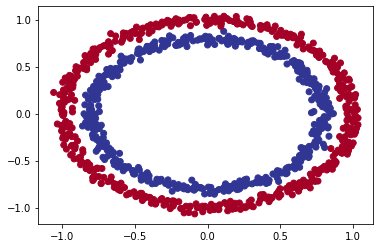

In [ ]:
# Visualize the data
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: the data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment with but still sizable enough to practice

### 1.1 Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [ ]:
# View the first example of features and labels
X_sample = X[ 0 ]
y_sample = y[ 0 ] 

print(f"Values for one sample of X: {X_sample} and same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and same for y: 1
Shapes for one sample of X: (2,) and same for y: ()


## 1.2 Turn data into tensors and created train and test splits



In [ ]:
import torch
torch.__version__

'1.13.0+cu116'

In [ ]:
#turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [ ]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [ ]:
# split data into training and test sets
from sklearn.model_selection import train_test_split
torch.manual_seed(42)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2, #.2 = 20% of data is test
                                                    random_state=42)


In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots

To do so, we want to:
1. Setup device agnostic code - runs on accelerator(gpu) if available
2. Construct a model (by subclassing `nn.Module`)
3. Define loss function and optimizer
4. Create a training and test loop

In [ ]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to tht target `device`


In [ ]:
# 1. Construct a model that subclasses nn.Module
class CricleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    # # 2. Create 2 nn.Linear layers capable of hendling the shapes of out data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
     return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. insantiate an instance of our model class and send it to the target device
model_0 = CricleModelV1().to(device)
model_0


CricleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [ ]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [ ]:
# make predictions with the model
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape {X_test.shape}")
print(f"\nFirst 10 predictions: \n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape torch.Size([200, 2])

First 10 predictions: 
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

for regression you might want MAE or MSE (mean absolute error or mean squared error)

for classification you might want binary cross entropy or categorical cross entropy (cross entropy)

As a reminder, the loss function measures how wrong the models predictions are

And for optimizers, 2 of the most useful are SGD and ADAM, but PyTorch has many built-in options.

* for the loss function we're going to use `torch.nn.BECWithLogitsLoss()`



In [ ]:
# setup the loss function
loss_fn = nn.BCELoss() # requires inputs to have gone through sigmoid activation function prior to being put in
loss_fn = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss - sigmoid activation function built in (GO WITH THIS ONE!!!)

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)


In [ ]:
# Calculate accuracy - out of 100 examples, what percent does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

To train our model, we're goint to need to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (bacpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.f. sigmoid for binary classification and sofmax for multiclass classification).

Then we can convert our model't prediction probabilities to **prediction labels** by either rounding them or taking the argmax().

In [ ]:
# View the first 5 outputs of the forward pass on the test data
model_0.train()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [ ]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

for our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [ ]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

#Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop



In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put the data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#build the training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # Do the forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # tun logits -> pred probs -> pred labels

  # calculate loss/accuracy
  loss = loss_fn(y_logits, y_train) ## nn.BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # loss backward (backpropagation)
  loss.backward()

  #optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  if epoch % 10 == 0:
    model_0.eval()
    with torch.inference_mode():
      # forward pass
      test_logits = model_0(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))

      #calculate test loss/accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_pred)
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69796 | Acc: 51.88% | Test Loss: 0.69440 | Test Acc: 58.00%
Epoch: 10 | Loss: 0.69590 | Acc: 51.25% | Test Loss: 0.69305 | Test Acc: 53.00%
Epoch: 20 | Loss: 0.69490 | Acc: 51.62% | Test Loss: 0.69254 | Test Acc: 49.50%
Epoch: 30 | Loss: 0.69435 | Acc: 51.12% | Test Loss: 0.69236 | Test Acc: 49.50%
Epoch: 40 | Loss: 0.69401 | Acc: 50.88% | Test Loss: 0.69232 | Test Acc: 51.00%
Epoch: 50 | Loss: 0.69378 | Acc: 50.25% | Test Loss: 0.69234 | Test Acc: 50.00%
Epoch: 60 | Loss: 0.69362 | Acc: 50.00% | Test Loss: 0.69239 | Test Acc: 51.50%
Epoch: 70 | Loss: 0.69351 | Acc: 50.25% | Test Loss: 0.69246 | Test Acc: 51.00%
Epoch: 80 | Loss: 0.69342 | Acc: 49.88% | Test Loss: 0.69254 | Test Acc: 50.00%
Epoch: 90 | Loss: 0.69336 | Acc: 49.88% | Test Loss: 0.69262 | Test Acc: 53.00%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

to inspect lets make some predictions and make them visual

To do so, we'te going to import a function called `plot_decision_boundry()`

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Lear PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

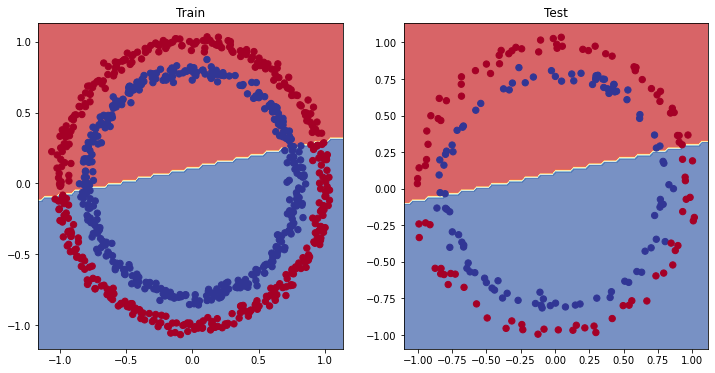

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn the patterns in the data
* Add more hidden units - go from 5 to 10, gives more chances too learn patterns
* Fit for longer
* change the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model and not the data

because these options are all values (as ML engineers and data scientists) can change, they are reffered to as **hyperparameters**.

lets try improving our model by:
* adding more hidden units 5 -> 10
* adding another layer 2 -> 3
* increase the number of epochs 100 -> 1000

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=10)
    self.layer_2 = nn.Linear(in_features=10,
                             out_features=10)
    self.layer_3 = nn.Linear(in_features=10,
                             out_features=1)
    
  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x))) #this way leverages speed ups where possible

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put the data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#build the training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_1.train()

  # Do the forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # tun logits -> pred probs -> pred labels

  # calculate loss/accuracy
  loss = loss_fn(y_logits, y_train) ## nn.BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # loss backward (backpropagation)
  loss.backward()

  #optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  if epoch % 100 == 0:
    model_1.eval()
    with torch.inference_mode():
      # forward pass
      test_logits = model_1(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))

      #calculate test loss/accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_pred)
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396 | Acc: 50.88% | Test Loss: 0.69261 | Test Acc: 51.00%
Epoch: 100 | Loss: 0.69305 | Acc: 50.38% | Test Loss: 0.69379 | Test Acc: 48.00%
Epoch: 200 | Loss: 0.69299 | Acc: 51.12% | Test Loss: 0.69437 | Test Acc: 46.00%
Epoch: 300 | Loss: 0.69298 | Acc: 51.62% | Test Loss: 0.69458 | Test Acc: 45.00%
Epoch: 400 | Loss: 0.69298 | Acc: 51.12% | Test Loss: 0.69465 | Test Acc: 46.00%
Epoch: 500 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69467 | Test Acc: 46.00%
Epoch: 600 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69468 | Test Acc: 46.00%
Epoch: 700 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69468 | Test Acc: 46.00%
Epoch: 800 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69468 | Test Acc: 46.00%
Epoch: 900 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69468 | Test Acc: 46.00%


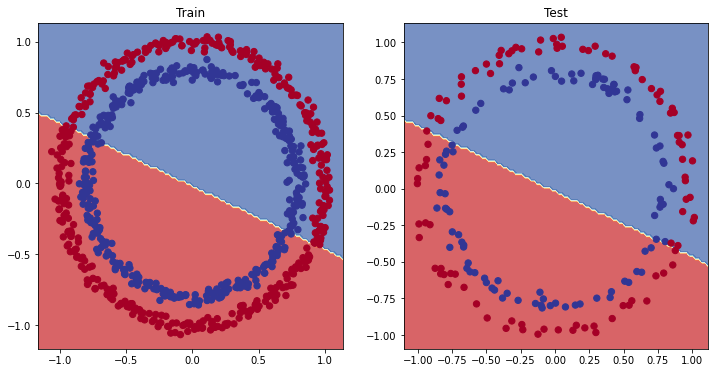

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)


### 5.1 Preparing data to see if our model can fit a strait line

One way to troubleshoot a larger problem is to test a smaller problem

In [ ]:
# create some data
weight = .7
bias = .3
start = 0
end = 1
step = .01

#create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]), tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Create train and test splits
train_split = int(.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

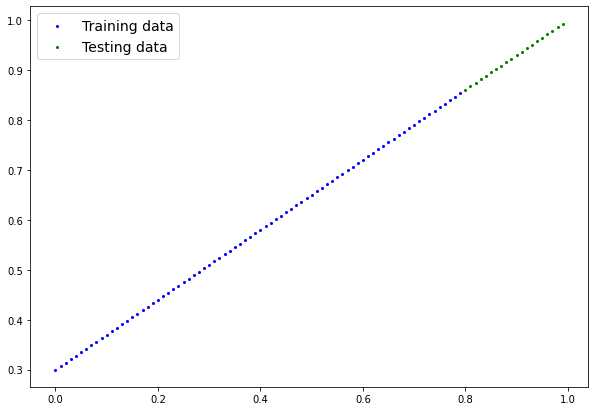

In [ ]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [ ]:
# same architecture as model_1 but using nn.Sequential
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss and Optimizer
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(model_2.parameters(), 
                            lr=0.01)

In [ ]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put the data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

#build the training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_2.train()

  # Do the forward pass
  y_pred = model_2(X_train_regression)


  # calculate loss/accuracy
  loss = loss_fn(y_pred, y_train_regression) ## nn.BCEWithLogitsLoss expects raw logits as input

  # Optimizer zero grad
  optimizer.zero_grad()

  # loss backward (backpropagation)
  loss.backward()

  #optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  if epoch % 100 == 0:
    model_1.eval()
    with torch.inference_mode():
      # forward pass
      test_pred = model_2(X_test_regression)

      #calculate test loss/accuracy
      test_loss = loss_fn(test_pred, y_test_regression)

    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")


Epoch: 0 | Loss: 0.75986 | Test Loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test Loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test Loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test Loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test Loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test Loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test Loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test Loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test Loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test Loss: 0.00360


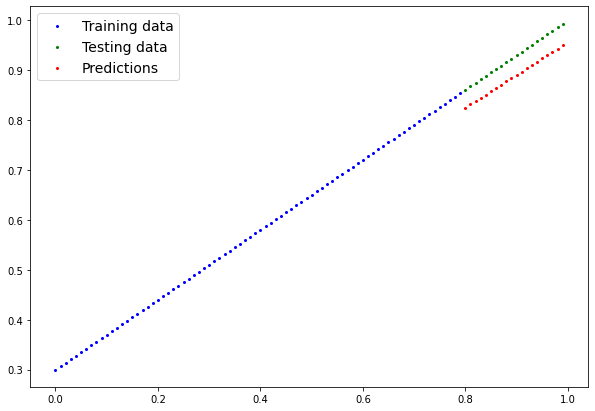

In [ ]:
model_2.eval()
with torch.inference_mode():
  # Do the forward pass
  y_pred = model_2(X_test_regression)

plot_predictions(X_train_regression.cpu(), y_train_regression.cpu(), X_test_regression.cpu(), y_test_regression.cpu(), predictions=y_pred.cpu())

## 6. The missing piece: non-linearity

with an "infinite" straight and non strait lines, we can create any pattern

### 6.1 Recreating non-linear data (red and blue circles)

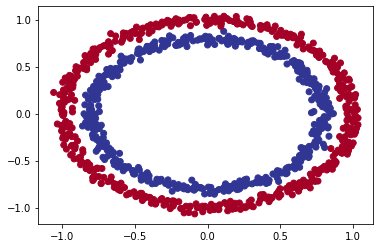

In [ ]:
# make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0],X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
# Conver data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split
# Turn data to tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]), tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity
* Linear - straight lines
* non-Linear - non straight lines

In [ ]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() #non-linear activation function

  def forward(self, x):
    # where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# Setup loss and optimizer

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.05)

### 6.3 Training a Model with non-linearity

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 2000

# Put the data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#build the training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_3.train()

  # Do the forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # tun logits -> pred probs -> pred labels

  # calculate loss/accuracy
  loss = loss_fn(y_logits, y_train) ## nn.BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # loss backward (backpropagation)
  loss.backward()

  #optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  if epoch % 100 == 0:
    model_3.eval()
    with torch.inference_mode():
      # forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))

      #calculate test loss/accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_pred)
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295 | Acc: 50.00% | Test Loss: 0.69322 | Test Acc: 50.00%
Epoch: 100 | Loss: 0.69181 | Acc: 58.38% | Test Loss: 0.69178 | Test Acc: 59.50%
Epoch: 200 | Loss: 0.69115 | Acc: 52.88% | Test Loss: 0.69103 | Test Acc: 52.50%
Epoch: 300 | Loss: 0.69050 | Acc: 52.88% | Test Loss: 0.69027 | Test Acc: 55.00%
Epoch: 400 | Loss: 0.68977 | Acc: 53.37% | Test Loss: 0.68940 | Test Acc: 55.00%
Epoch: 500 | Loss: 0.68894 | Acc: 53.50% | Test Loss: 0.68841 | Test Acc: 56.00%
Epoch: 600 | Loss: 0.68795 | Acc: 53.00% | Test Loss: 0.68724 | Test Acc: 56.00%
Epoch: 700 | Loss: 0.68676 | Acc: 52.62% | Test Loss: 0.68588 | Test Acc: 56.50%
Epoch: 800 | Loss: 0.68516 | Acc: 52.75% | Test Loss: 0.68413 | Test Acc: 56.50%
Epoch: 900 | Loss: 0.68325 | Acc: 52.75% | Test Loss: 0.68199 | Test Acc: 56.00%
Epoch: 1000 | Loss: 0.68101 | Acc: 52.75% | Test Loss: 0.67942 | Test Acc: 56.50%
Epoch: 1100 | Loss: 0.67835 | Acc: 53.37% | Test Loss: 0.67642 | Test Acc: 56.00%
Epoch: 1200 | Loss: 0.67512 

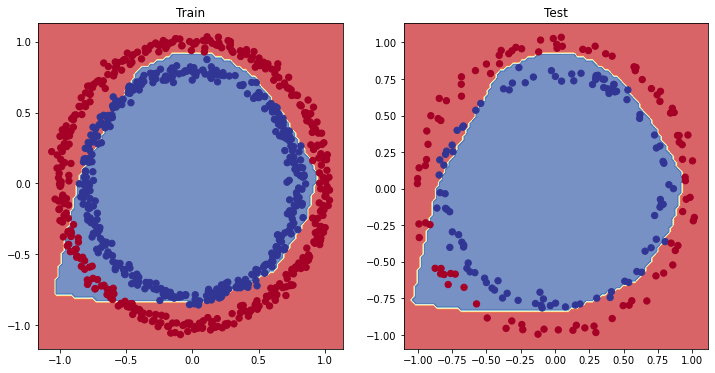

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data on its own

And these tools are linear & non-linear functions

In [ ]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

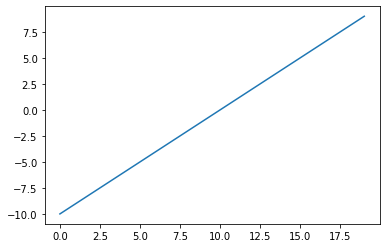

In [ ]:
# Visualize the tensor
plt.plot(A)

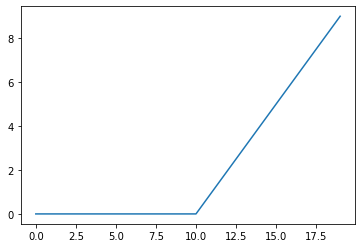

In [ ]:
plt.plot(torch.relu(A))

In [ ]:
#create custom function for ReLU
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0), x) #inputs must be tensor

In [ ]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

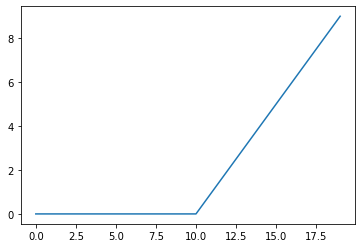

In [ ]:
# Plot ReLU activation function
plt.plot(relu(A))

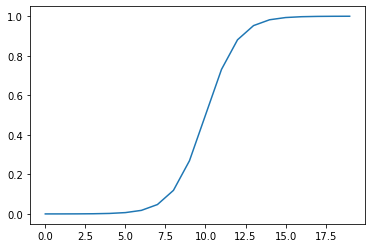

In [ ]:
# Now let's do the same for sigmoid
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

plt.plot(sigmoid(A))

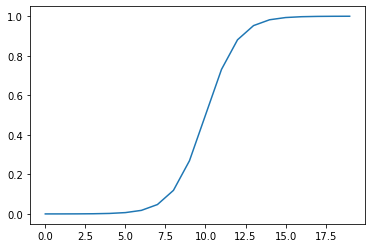

In [ ]:
plt.plot(torch.sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs. dog, spam vs non spam, fraud or not fraud)
* Multi-class classification = more than one thing or another (dog vs cat vs chicken)

### 8.1 Creating a toy multi-class dataset

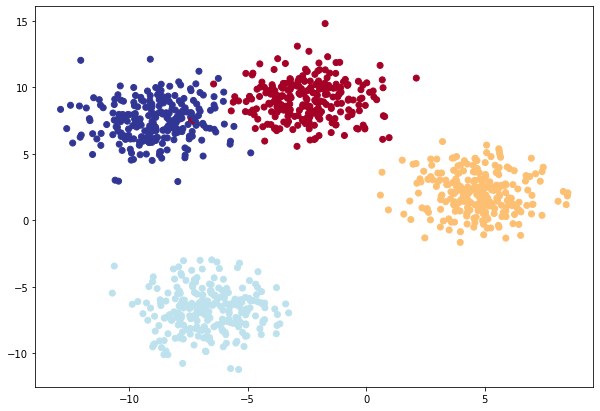

In [ ]:
#import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# wet hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob, = make_blobs(n_samples=1000,
                             n_features=NUM_FEATURES,
                             centers=NUM_CLASSES,
                             cluster_std=1.5,
                             random_state=RANDOM_SEED)

# 2. turn data into tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=.2,
                                                                        random_state=RANDOM_SEED)

# 4. Visualize
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in PyTorch

In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    """Initializes multi-class classification.
    
    Args:
      input_features (int): Number of input features o the model
      output_features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:
      None
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)

# Create instance and send to target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4.to(device)

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and optimizer for a multi-class classification model

In [ ]:
# loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels

Logits -> pred probs (use `torch.softmax()`) -> pred labels (take the `argmax()` of the prediction probabilities)

In [ ]:
# lets get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))
y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [ ]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [ ]:
# convert model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [ ]:
# Convert model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

### 8.5 Create training and testing loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put the data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

#build the training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_4.train()

  # Do the forward pass
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # calculate loss/accuracy
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # loss backward (backpropagation)
  loss.backward()

  #optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  if epoch % 10 == 0:
    model_4.eval()
    with torch.inference_mode():
      # forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

      #calculate test loss/accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                            y_pred=test_pred)
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15883 | Acc: 40.38% | Test Loss: 1.07554 | Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476 | Acc: 96.75% | Test Loss: 0.66069 | Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535 | Acc: 98.50% | Test Loss: 0.43074 | Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294 | Acc: 99.12% | Test Loss: 0.24508 | Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232 | Acc: 99.25% | Test Loss: 0.10229 | Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627 | Acc: 99.25% | Test Loss: 0.05848 | Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068 | Acc: 99.25% | Test Loss: 0.04293 | Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300 | Acc: 99.25% | Test Loss: 0.03491 | Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836 | Acc: 99.25% | Test Loss: 0.02988 | Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525 | Acc: 99.25% | Test Loss: 0.02663 | Test Acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [ ]:
# make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred = y_pred_probs.argmax(dim=1)

print(y_pred==y_blob_test)

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

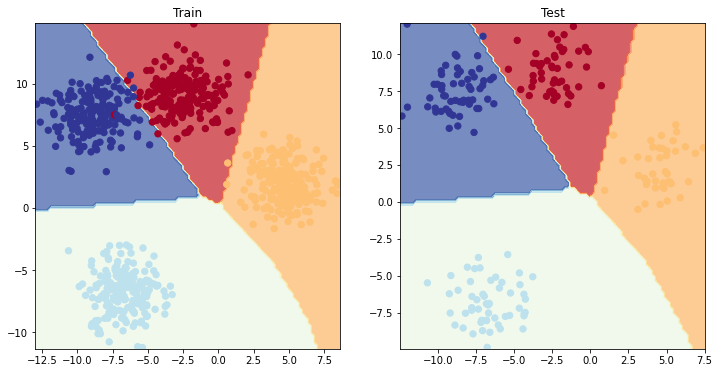

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - out of 100 samples, how many did our model get right
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchmetrics import Accuracy

# setup metric
torchmetric_accuracy = Accuracy().to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test) 



TypeError: ignored